# Steps to perform (Project level)

1) Fetch the data from Kaggle, analyze it with statistical descriptions and visualizations (pandas profiler), time series analysis, perform dimensionality reduction, clean it (impute missing data), subsample data and handle class imbalance.
2) Load data to S3 and Create train, validation and test dataset on AWS Sagemaker (CV)
3) Decide upon the best metric
4) Use Autoglunon for identifying the best model
5) Perform hyperparameter tuning (regularization, ensure overfitting)
6) Train the model
7) Test the model
8) Deploy the model
9) Create lambda to interact with model
Bonus:
10) Attempt inference with batch processor
11) Try to deploy 2 different models with bagging and boosting
12) Test the results on Kaggle

Surplus:
Python documentation and comments convention

In [1]:
!pip install autogluon --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.3/218.3 kB 154.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 222.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 257.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 299.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 216.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 192.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 166.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 245.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 346.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installin

In [2]:
# Import required packages
import sagemaker
import pandas as pd
from autogluon.tabular import TabularPredictor

In [3]:
#Set Sagemaker variables
session = sagemaker.Session()
def_bucket = session.default_bucket()
role = sagemaker.get_execution_role()

In [4]:
#Ensure Sagemaker variable values are correctly set
print("Default Bucket: {}".format(def_bucket))
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-004538843871
RoleArn: arn:aws:iam::004538843871:role/service-role/AmazonSageMaker-ExecutionRole-20230328T233092


In [5]:
bucket = "mle-capstone"
prefix = ""

In [6]:
# Command to download and unzip data (This command needs to be executed once)
session.download_data(path="data", bucket=bucket, key_prefix=prefix)

In [7]:
!unzip -o data/itr3.zip

Archive:  data/itr3.zip
   creating: itr3/
  inflating: itr3/valid.csv          
  inflating: itr3/test.csv           
  inflating: __MACOSX/itr3/._test.csv  
  inflating: itr3/train.csv          


In [8]:
df_train = pd.read_csv("itr3/train.csv")
df_train.head()

,CID_month,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0.617846,0.400025,0.0,0.954861,0.023890,0.003140,0.225845,0.0,1.175081,0.184974,...,-1.0,-1.0,1.0,0.0,0.870115,0.141214,1.0,0.008945,8,1
1,0.056885,0.405788,0.0,0.944042,0.025613,0.008950,0.225845,0.0,1.177973,0.184974,...,-1.0,-1.0,1.0,0.0,0.864712,0.145885,1.0,0.002125,8,1
2,0.747059,0.403615,1.0,0.940261,0.026016,0.009074,0.225845,0.0,1.175785,0.184974,...,-1.0,-1.0,1.0,0.0,0.871729,0.144555,1.0,0.000765,8,1
3,0.189565,0.391495,1.0,0.936253,0.029538,0.005778,0.225845,0.0,1.174703,0.184974,...,-1.0,-1.0,1.0,0.0,0.869414,0.151890,1.0,0.008195,8,1
4,0.148649,0.392356,1.0,0.915764,0.028671,0.008595,0.225845,0.0,1.177958,0.184974,...,-1.0,-1.0,1.0,0.0,0.869089,0.152654,1.0,0.001493,8,1


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91000 entries, 0 to 90999
Columns: 190 entries, CID_month to target
dtypes: float64(188), int64(2)
memory usage: 131.9 MB


In [10]:
df_train.describe()

,CID_month,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
count,91000.000000,91000.000000,91000.000000,91000.000000,91000.000000,9.100000e+04,91000.000000,91000.000000,9.100000e+04,91000.000000,...,91000.000000,91000.000000,91000.000000,91000.000000,91000.000000,91000.000000,91000.000000,9.100000e+04,91000.000000,91000.000000
mean,0.500695,0.569465,6.033396,0.172012,0.509401,1.301276e-01,0.258683,0.088818,1.896582e-01,0.191610,...,-0.948341,-0.932011,0.175165,0.021473,0.183044,0.389787,0.174923,5.315014e-02,0.721429,0.500000
std,0.289043,0.262256,10.828274,0.249182,0.420157,2.944498e-01,0.207604,0.266020,2.701879e-01,0.097685,...,0.223661,0.316583,0.430104,0.197013,0.364640,0.108536,0.429922,1.832865e-01,2.392056,0.500003
min,0.000024,-0.383019,0.000000,-0.719199,0.000003,2.970408e-08,-0.254707,0.000000,4.138581e-07,-0.000219,...,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-0.013947,-1.000000,2.310564e-07,-1.000000,0.000000
25%,0.249871,0.382252,0.000000,0.012775,0.045620,3.145549e-03,0.148876,0.000000,6.643764e-03,0.184974,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.390799,0.000000,2.778111e-03,0.000000,0.000000
50%,0.500609,0.564151,0.000000,0.059323,0.714074,6.304529e-03,0.204935,0.000000,3.559861e-02,0.184974,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.390799,0.000000,5.551463e-03,0.000000,0.500000
75%,0.751367,0.798878,9.000000,0.219176,1.000030,9.468715e-03,0.286087,0.000000,2.925495e-01,0.184974,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.390799,0.000000,8.348133e-03,0.000000,1.000000
max,0.999989,1.009998,181.000000,1.324053,1.010000,2.507711e+00,2.648463,5.465303,1.625262e+00,2.685152,...,1.000000,3.000000,1.000000,1.000000,1.174753,1.751388,1.000000,1.343284e+00,47.000000,1.000000


In [11]:
df_test = pd.read_csv("itr3/test.csv")
df_test.head()

,CID_month,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0.598223,0.983642,21.0,0.119183,0.190159,0.002932,0.105605,0.0,0.055054,0.184974,...,-1.0,-1.0,0.0,0.0,0.000000,0.390799,0.0,0.002857,0,0
1,0.874847,0.694377,1.0,0.682299,0.047326,0.001818,0.181180,0.0,0.597706,0.184974,...,-1.0,-1.0,0.0,0.0,0.000000,0.390799,0.0,0.009433,0,0
2,0.651878,0.815644,0.0,0.014352,1.008587,0.006154,0.095020,0.0,0.009350,0.184974,...,-1.0,-1.0,0.0,0.0,0.000000,0.390799,0.0,0.002908,0,0
3,0.830397,0.532449,0.0,0.044663,0.236369,0.001371,0.128847,0.0,0.028740,0.071464,...,-1.0,-1.0,1.0,0.0,0.867847,0.502085,1.0,0.003663,7,1
4,0.887044,0.889490,0.0,0.006211,0.819388,0.002297,0.225845,0.0,0.007111,0.184974,...,-1.0,-1.0,1.0,0.0,0.941117,0.383798,1.0,0.356398,1,0


In [12]:
predictor = TabularPredictor(label="target", eval_metric="f1", problem_type="binary").fit(train_data=df_train, time_limit=600, presets = "best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20230404_200519/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230404_200519/"
AutoGluon Version:  0.7.0
Python Version:     3.10.8
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Dec 8 01:29:11 UTC 2022
Train Data Rows:    91000
Train Data Columns: 189
Label Column: target
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2500.2400000000002 MB
	Train Data (Original)  Memory Usage: 137.59 MB (5.5% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the

[1000]	valid_set's binary_logloss: 0.147934	valid_set's f1: 0.949711


	Ran out of time, early stopping on iteration 1172. Best iteration is:
	[1172]	valid_set's binary_logloss: 0.136363	valid_set's f1: 0.955319


[1000]	valid_set's binary_logloss: 0.153783	valid_set's f1: 0.945323


	Ran out of time, early stopping on iteration 1190. Best iteration is:
	[1179]	valid_set's binary_logloss: 0.141264	valid_set's f1: 0.950247


[1000]	valid_set's binary_logloss: 0.155231	valid_set's f1: 0.94622


	Ran out of time, early stopping on iteration 1098. Best iteration is:
	[1087]	valid_set's binary_logloss: 0.148781	valid_set's f1: 0.949258


[1000]	valid_set's binary_logloss: 0.158782	valid_set's f1: 0.942477


	Ran out of time, early stopping on iteration 1288. Best iteration is:
	[1288]	valid_set's binary_logloss: 0.138829	valid_set's f1: 0.953867


[1000]	valid_set's binary_logloss: 0.152155	valid_set's f1: 0.944761


	Ran out of time, early stopping on iteration 1348. Best iteration is:
	[1343]	valid_set's binary_logloss: 0.129934	valid_set's f1: 0.95619


[1000]	valid_set's binary_logloss: 0.148255	valid_set's f1: 0.947951


	Ran out of time, early stopping on iteration 1418. Best iteration is:
	[1417]	valid_set's binary_logloss: 0.122051	valid_set's f1: 0.959813


[1000]	valid_set's binary_logloss: 0.15055	valid_set's f1: 0.947578


	Ran out of time, early stopping on iteration 1444. Best iteration is:
	[1444]	valid_set's binary_logloss: 0.123457	valid_set's f1: 0.958968


[1000]	valid_set's binary_logloss: 0.153157	valid_set's f1: 0.946532


	Ran out of time, early stopping on iteration 1820. Best iteration is:
	[1807]	valid_set's binary_logloss: 0.108	valid_set's f1: 0.967439
	0.9564	 = Validation score   (f1)
	418.28s	 = Training   runtime
	12.06s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 11.92s of the 11.92s of remaining time.
	Memory not enough to fit LGBModel folds in parallel. Will do sequential fitting instead. 	Consider decreasing folds trained in parallel by passing num_folds_parallel to ag_args_ensemble when calling predictor.fit
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1. Best iteration is:
	[1]	valid_set's binary_logloss: 0.666418	valid_set's f1: 0.856426
	Time limit exceeded... Skipping LightGBM_BAG_L1.
Fitting model: RandomForestGini_BAG_L1 ... Training model for up to 7.68s of the 7.68s of remaining time.
	Time limit exceeded... Skipping RandomForestGini_BAG_L1.
Fitting model: 

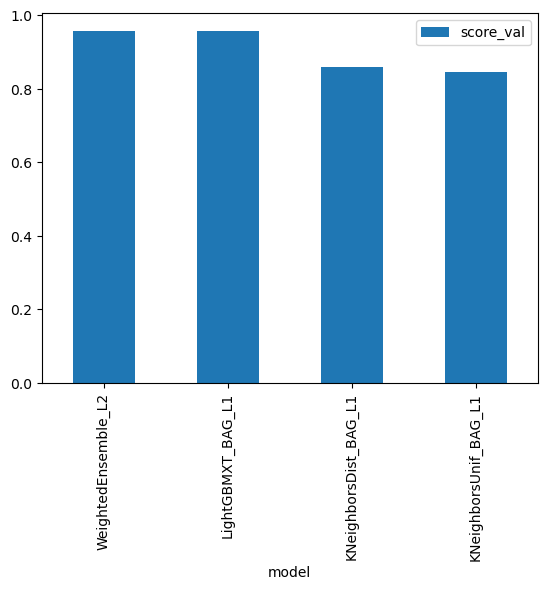

In [13]:
# Output the model's `score_val` in a bar chart to compare performance
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val");

In [14]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                   model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    WeightedEnsemble_L2   0.957356      86.100820  432.422132                0.177111          13.435859            2       True          4
1      LightGBMXT_BAG_L1   0.956384      12.056895  418.279702               12.056895         418.279702            1       True          3
2  KNeighborsDist_BAG_L1   0.859319      73.866814    0.706571               73.866814           0.706571            1       True          2
3  KNeighborsUnif_BAG_L1   0.844351      70.774323    0.830502               70.774323           0.830502            1       True          1
Number of models trained: 4
Types of models trained:
{'WeightedEnsembleModel', 'StackerEnsembleModel_LGB', 'StackerEnsembleModel_KNN'}
Bagging used: True  (with 8 folds)
Multi-layer stack-ensembling used: False 
Feature Metadata (Pro

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': 0.8443510083313868,
  'KNeighborsDist_BAG_L1': 0.859319225594093,
  'LightGBMXT_BAG_L1': 0.9563842346391708,
  'WeightedEnsemble_L2': 0.9573562384237947},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif_BAG_L1': 'AutogluonModels/ag-20230404_200519/models/KNeighborsUnif_BAG_L1/',
  'KNeighborsDist_BAG_L1': 'AutogluonModels/ag-20230404_200519/models/KNeighborsDist_BAG_L1/',
  'LightGBMXT_BAG_L1': 'AutogluonModels/ag-20230404_200519/models/LightGBMXT_BAG_L1/',
  'WeightedEnsemble_L2': 'AutogluonModels/ag-20230404_200519/models/WeightedEnsemble_L2/'},
 'model_fit_times': {'KNeighborsUnif_BAG_L1': 0.8305015563964844,
  'KNeighborsDist_BAG_L1': 0.706571102142334,
  'LightGBMXT_BAG_L1': 418.279702186

In [15]:
predictions = predictor.predict(df_test)
predictions.head(50)

0     0
1     1
2     0
3     0
4     0
5     0
6     1
7     0
8     1
9     1
10    0
11    1
12    0
13    0
14    1
15    0
16    0
17    0
18    0
19    1
20    0
21    0
22    0
23    1
24    0
25    0
26    0
27    1
28    0
29    0
30    0
31    1
32    0
33    0
34    0
35    0
36    0
37    1
38    0
39    0
40    1
41    0
42    1
43    1
44    1
45    0
46    0
47    0
48    1
49    1
Name: target, dtype: int64

In [16]:
perf = predictor.evaluate_predictions(y_true=df_test.target, y_pred=predictions, auxiliary_metrics=False)

Evaluation: f1 on test data: 0.7455391776570984
Evaluations on test data:
{
    "f1": 0.7455391776570984
}
